In [70]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
# to save and write as pngs
from imageio import imwrite, imread
import math
from scipy import ndimage as ndi
# import geopandas
# from scipy.ndimage.filters import gaussian_filter, sobel
from skimage.filters import roberts, sobel, scharr, prewitt, gaussian
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN


In [2]:
def plt_fig_hist(image):
    plt.figure(figsize=(12,12));
    plt.subplot(1, 2, 1);
    plt.imshow(image, cmap='gray');
    plt.xlabel('x');
    plt.ylabel('y');
    plt.subplot(1, 2, 2);
    uniqe = np.unique(image, return_counts=True);
    plt.plot(uniqe[0],uniqe[1]);
    plt.xlabel('values');
    plt.ylabel('counts');
    plt.show();
    
def print_info(image):
    unique = np.unique(image);
    print('The first 5 values in the image: \n', unique[0:5]);
    print('The maximum value is: {}, and minimum is: {}'.format(np.max(image), np.min(image)));
    print('The mean value is: {}, and the median is: {}'.format(np.mean(image), np.median(image)));
    print('Total Number of values in the image: ',len(unique));
    print('The image size: {}, dimensions: {} and the shape: {}'.format(image.size, image.ndim, image.shape));    
    
def give_transferMatrix(scaling):
    sx=scaling[0]
    sy=scaling[1]
    scale_matrix = [[sx, 0],
                [0, sy]]
    return scale_matrix

def build_weighMatrix(image, radius=None):
    if radius == None:
        radius = image.shape[0]/5;
    else:
        radius = radius;
        
    G = np.zeros((image.shape[0]**2,image.shape[1]**2));
    std_img = np.std(image);
    indices_dict = build_indices_dict(image);
    
    for i in range(G.shape[0]):
        for j in range(G.shape[1]):            
            distance_diff = calc_node_distance(indices_dict[i], indices_dict[j]);
            if int(np.round(distance_diff)) < radius:
                distance_diff = np.exp(-distance_diff/(len(image)*0.1));
            else:
                distance_diff = 0;
            intens_diff = np.exp(-calc_nodes_intens_diff(image[indices_dict[i]], image[indices_dict[j]])/std_img)
            G[i,j] = intens_diff * distance_diff;
    return G;

def calc_node_distance(nodeA, nodeB):    
    dis_deff = np.sqrt(np.power(nodeA[0]-nodeB[0], 2) + np.power(nodeA[1]-nodeB[1], 2));
    return dis_deff;

def calc_nodes_intens_diff(intensityA, intensityB):
    intens_diff = np.sqrt(np.power(intensityA - intensityB, 2));
    return intens_diff;

def build_indices_dict(image):
    indices = dict()
    s = 0
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            indices[s] = (i, j)
            s += 1
    return indices

# def sobel_edge_filters(img):
#     Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
#     Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
#     Ix = ndi.filters.convolve(img, Kx)
#     Iy = ndi.filters.convolve(img, Ky)
    
#     G = np.hypot(Ix, Iy)
#     G = G / G.max()# * 255
#     theta = np.arctan2(Iy, Ix)
    
#     return (G, theta)

# def gaussian_blur_kernel(kernel_size, sigma=1):
#     size = int(kernel_size) // 2
#     x, y = np.mgrid[-size:size+1, -size:size+1]
#     normal = 1 / (2.0 * np.pi * sigma**2)
#     g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
#     return g

In [3]:
# image = imread("testImagio_dicom.png");
im_obj = sitk.ReadImage('data/IMG-0002-00074.dcm');
mask_groundtruth = sitk.ReadImage('data/liver_GT_074.png')
im_array = sitk.GetArrayViewFromImage(im_obj)
im_array_squeezed = im_array.squeeze()
image = im_array_squeezed;
groundtruth_mask_array = sitk.GetArrayFromImage(mask_groundtruth)

In [149]:
# gdf = geopandas.GeoDataFrame(image);
# gdf

In [202]:
# print_info(image);
# plt_fig_hist(image);

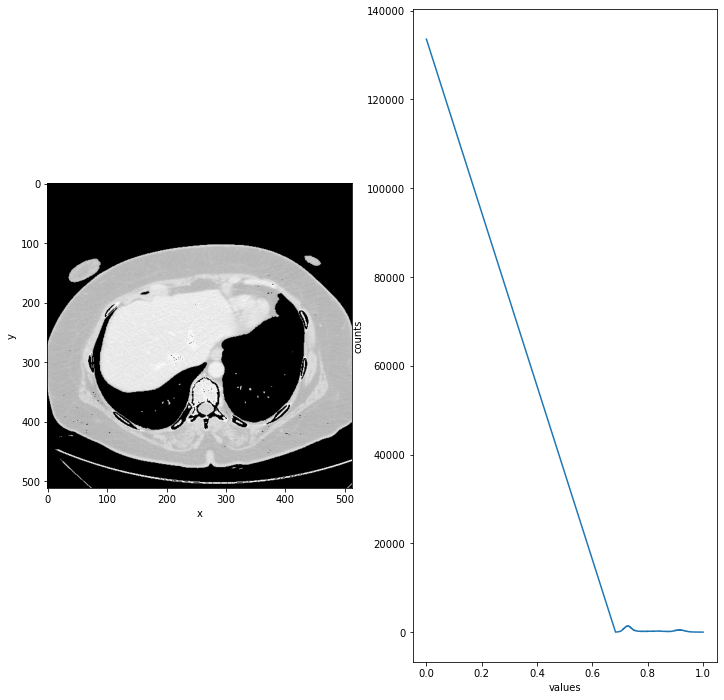

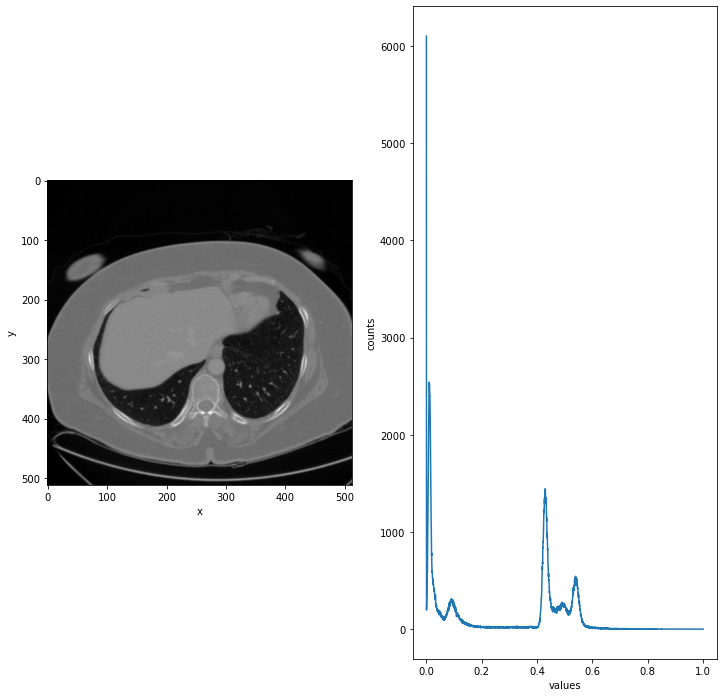

In [4]:
# thresh values out of interest from original image 
threshed_img = np.array(image);
threshed_img.setflags(write=1); # allow clipping values

threshed_img[threshed_img < -160] = -1024; # the region of the liver, set others as background!
threshed_img[threshed_img > 240] = -1024;

threshed_norm_img = np.sqrt((threshed_img+np.abs(np.min(threshed_img)))**2); # add an offset to 'remove' negative values
threshed_norm_img = threshed_norm_img/np.max(threshed_norm_img); # normalize

norm_img = np.sqrt((image+np.abs(np.min(image)))**2); # add an offset to 'remove' negative values
norm_img = norm_img/np.max(norm_img); # normalize 

plt_fig_hist(threshed_norm_img)
plt_fig_hist(norm_img)


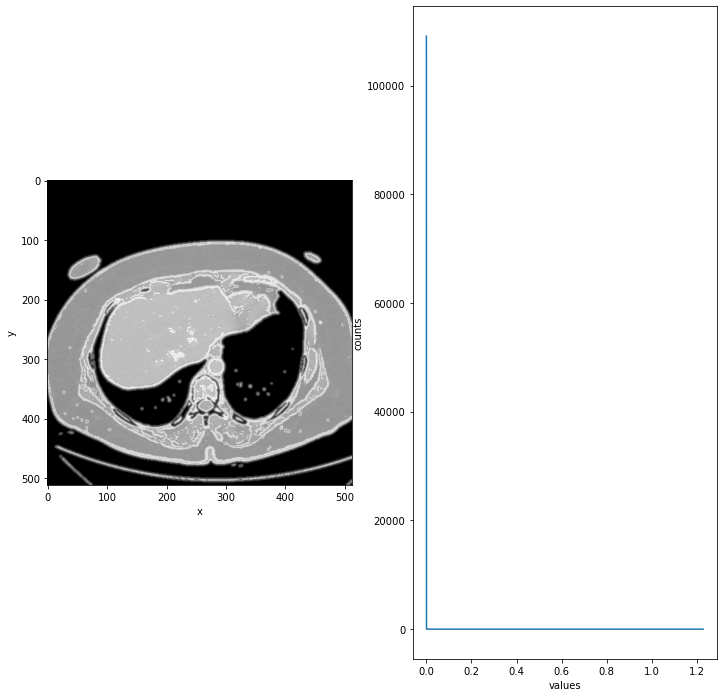

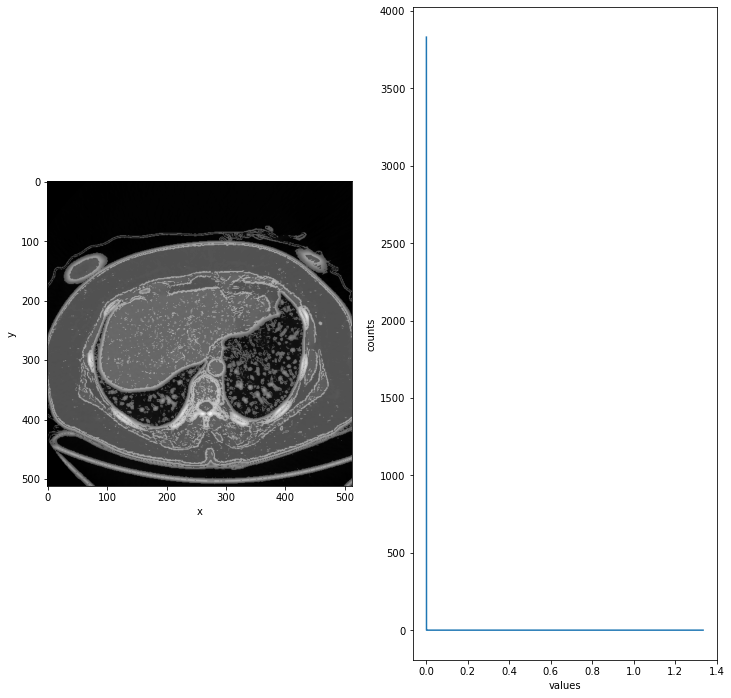

In [34]:
# amplify edges

threshed_norm_noiseless_img = gaussian(threshed_norm_img, sigma=1)
norm_noiseless_img = gaussian(norm_img, sigma=1)

threshed_norme_sobel = sobel(threshed_norm_noiseless_img)
norm_img_sobel = sobel(norm_img)

threshed_norme_sobel = (threshed_norme_sobel>0.02)
tmp = np.zeros((threshed_norme_sobel.shape))
tmp[threshed_norme_sobel==1] = np.median(threshed_norm_noiseless_img); threshed_norme_sobel = tmp

norm_img_sobel = (norm_img_sobel>0.02)
tmp = np.zeros((norm_img_sobel.shape))
tmp[norm_img_sobel==1] = np.median(norm_noiseless_img); norm_img_sobel = tmp

# plt_fig_hist(threshed_norme_sobel)
# plt_fig_hist(norm_img_sobel)

threshed_img_edge_amplified = threshed_norme_sobel+threshed_norm_noiseless_img
img_edge_amplified = norm_img_sobel + norm_noiseless_img
plt_fig_hist(threshed_img_edge_amplified)
plt_fig_hist(img_edge_amplified)


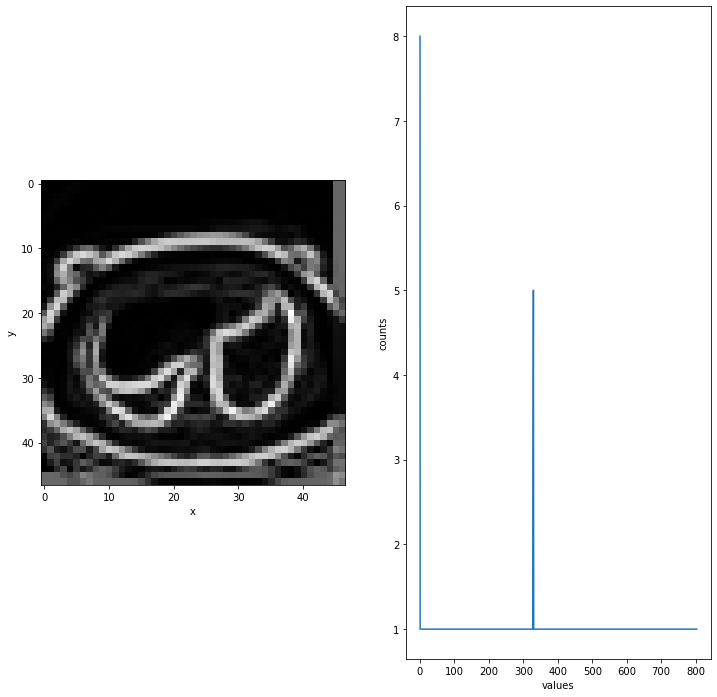

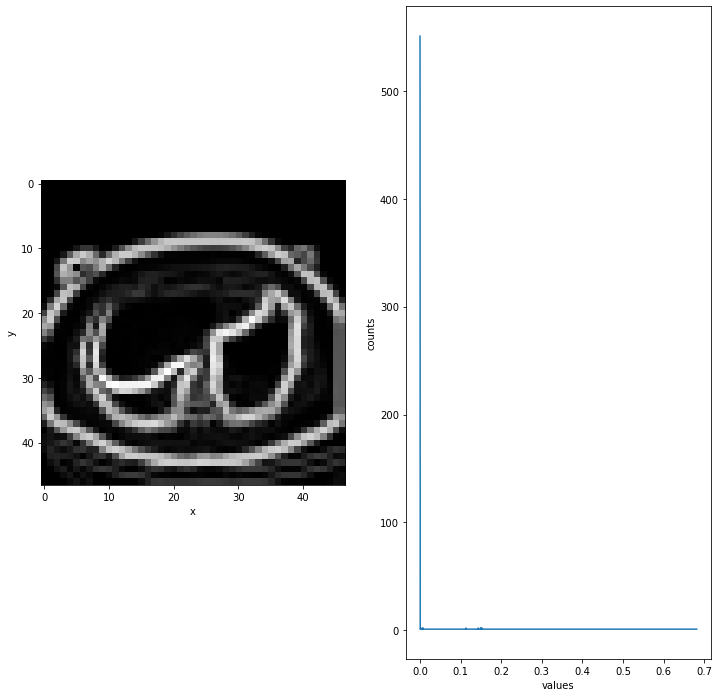

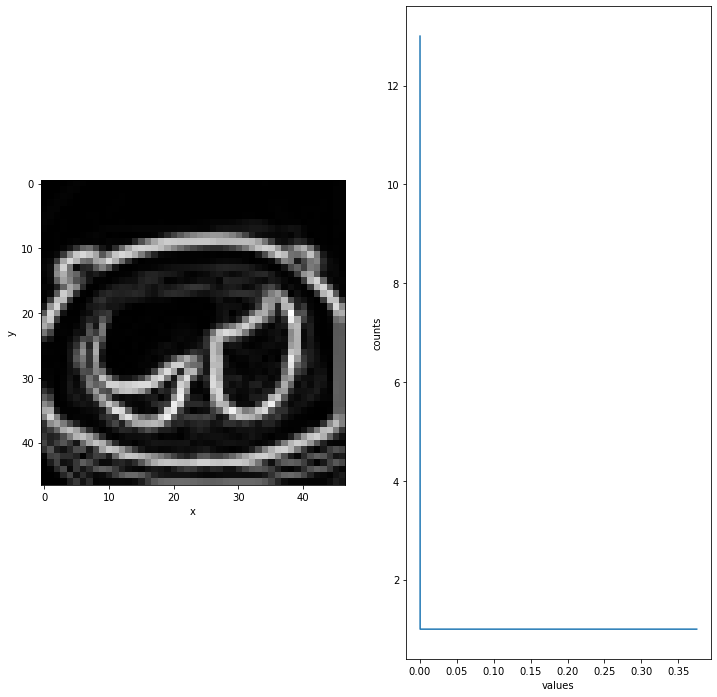

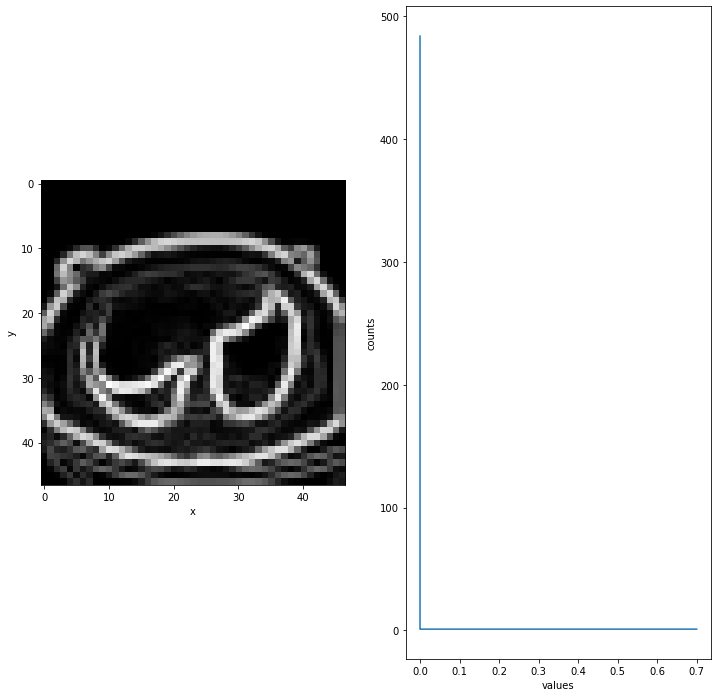

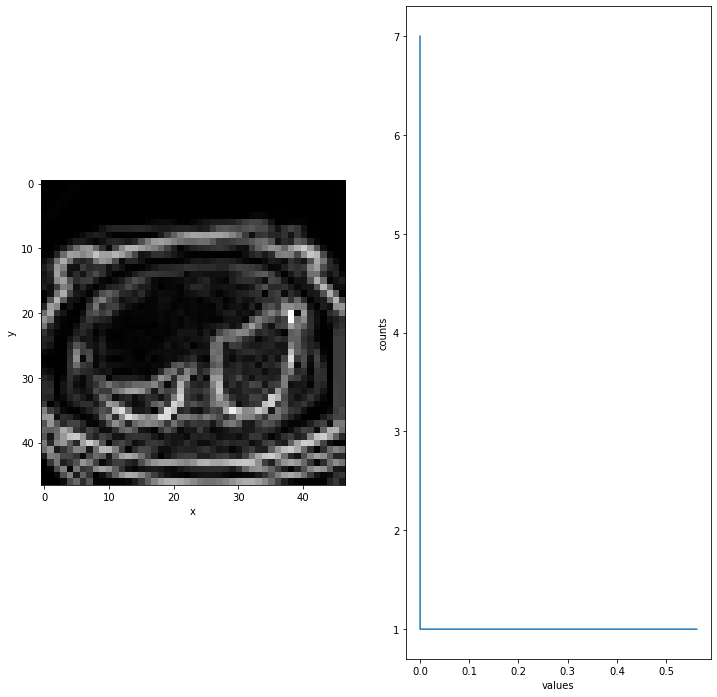

In [295]:
# Another scaling method
from skimage.measure import block_reduce
scaling_factor = 11

_image = block_reduce(image, block_size=(scaling_factor, scaling_factor), func=np.mean)
_mask= block_reduce(groundtruth_mask_array, block_size=(scaling_factor, scaling_factor), func=np.mean)

threshed_img = block_reduce(threshed_norm_img, block_size=(scaling_factor, scaling_factor), func=np.mean)
nonThreshed_img = block_reduce(norm_img, block_size=(scaling_factor, scaling_factor), func=np.mean) # normalized but non threshed

threshed_img_edge_amplified = block_reduce(threshed_img_edge_amplified, block_size=(scaling_factor, scaling_factor), func=np.mean)
nonThreshed_img_edge_amplified = block_reduce(img_edge_amplified, block_size=(scaling_factor, scaling_factor), func=np.mean)

plt_fig_hist(sobel(_image))
plt_fig_hist(sobel(threshed_img))
plt_fig_hist(sobel(nonThreshed_img))
plt_fig_hist(sobel(threshed_img_edge_amplified))
plt_fig_hist(sobel(nonThreshed_img_edge_amplified))


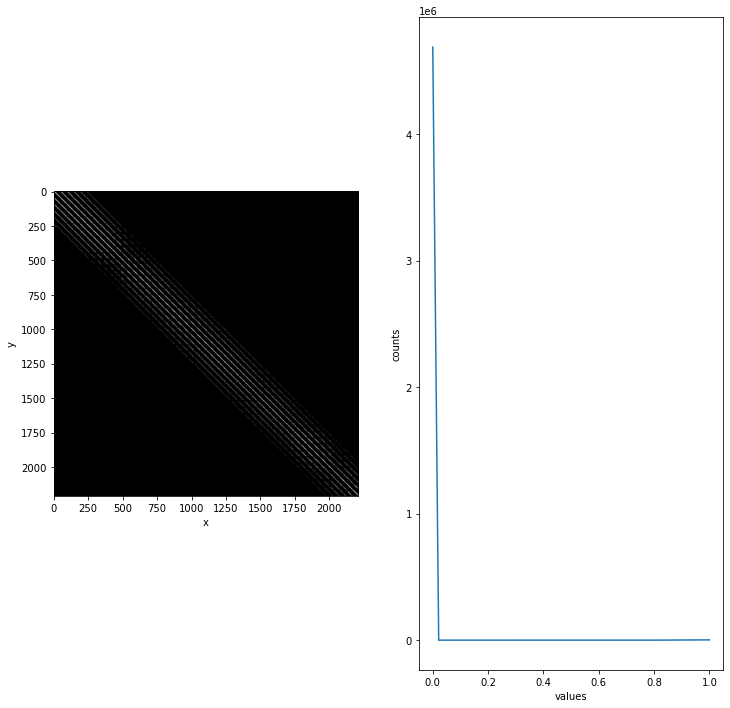

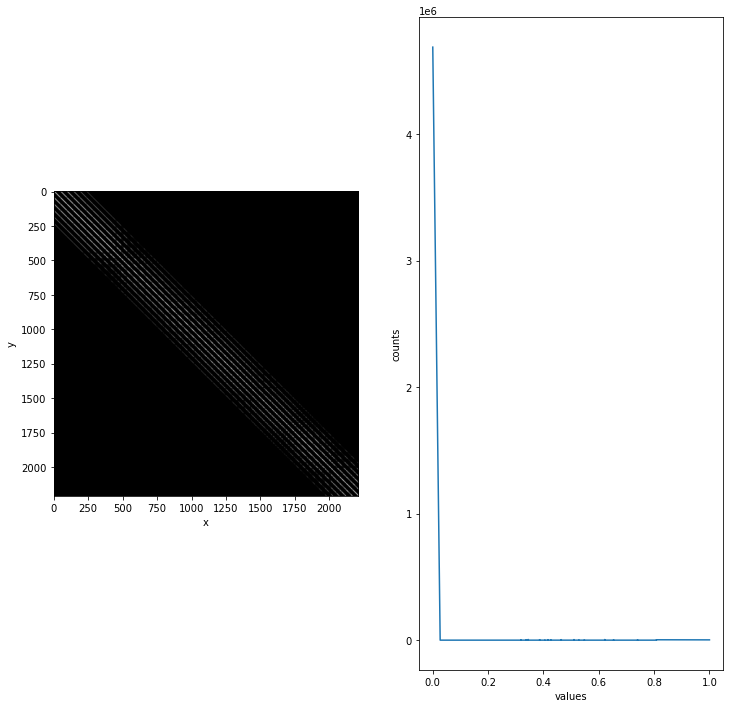

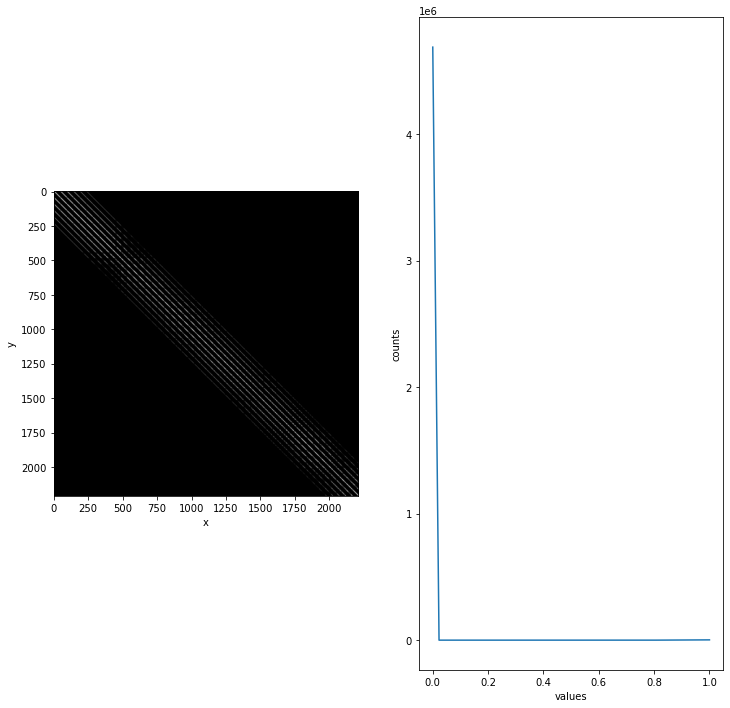

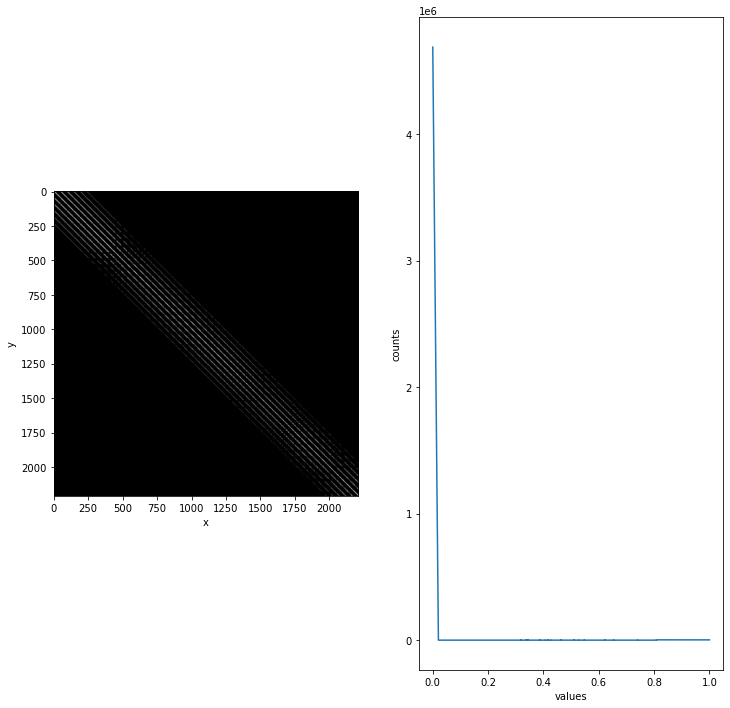

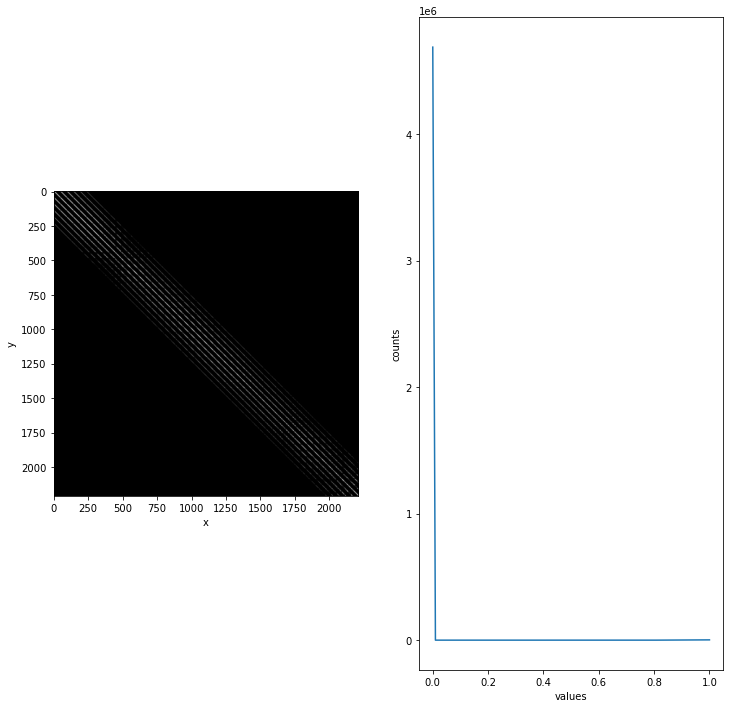

In [383]:
wm_img = build_weighMatrix(_image, 6);
wm_norm_img = build_weighMatrix(nonThreshed_img, 6);
wm_threshed_norm_img = build_weighMatrix(threshed_img, 6);

wm_threshed_img_amplified = build_weighMatrix(threshed_img_edge_amplified, 6);
wm_nonThreshed_img_amplified = build_weighMatrix(nonThreshed_img_edge_amplified, 6);

plt_fig_hist(wm_img)
plt_fig_hist(wm_threshed_norm_img)
plt_fig_hist(wm_norm_img)
plt_fig_hist(wm_threshed_img_amplified)
plt_fig_hist(wm_nonThreshed_img_amplified)

In [362]:
clusters = 15
labels ='discretize' # 'kmeans'

clustering_img = SpectralClustering(n_clusters=clusters,assign_labels=labels,random_state=0).fit(wm_img)
clustering_norm_img = SpectralClustering(n_clusters=clusters,assign_labels=labels,random_state=0).fit(wm_norm_img)
clustering_threshed_norm_img = SpectralClustering(n_clusters=clusters,assign_labels=labels,random_state=0).fit(wm_threshed_norm_img)

clustering_threshed_img_amplified = SpectralClustering(n_clusters=clusters,assign_labels=labels,random_state=0).fit(wm_threshed_img_amplified)
clustering_nonThreshed_img_amplified = SpectralClustering(n_clusters=clusters,assign_labels=labels,random_state=0).fit(wm_nonThreshed_img_amplified)

labels_img = clustering_img.labels_.reshape(_image.shape)
labels_norm_img = clustering_norm_img.labels_.reshape(_image.shape)
labels_threshed_norm_img = clustering_threshed_norm_img.labels_.reshape(_image.shape)

labels_threshed_img_amplified = clustering_threshed_img_amplified.labels_.reshape(_image.shape)
labels_nonThreshed_img_amplified = clustering_nonThreshed_img_amplified.labels_.reshape(_image.shape)


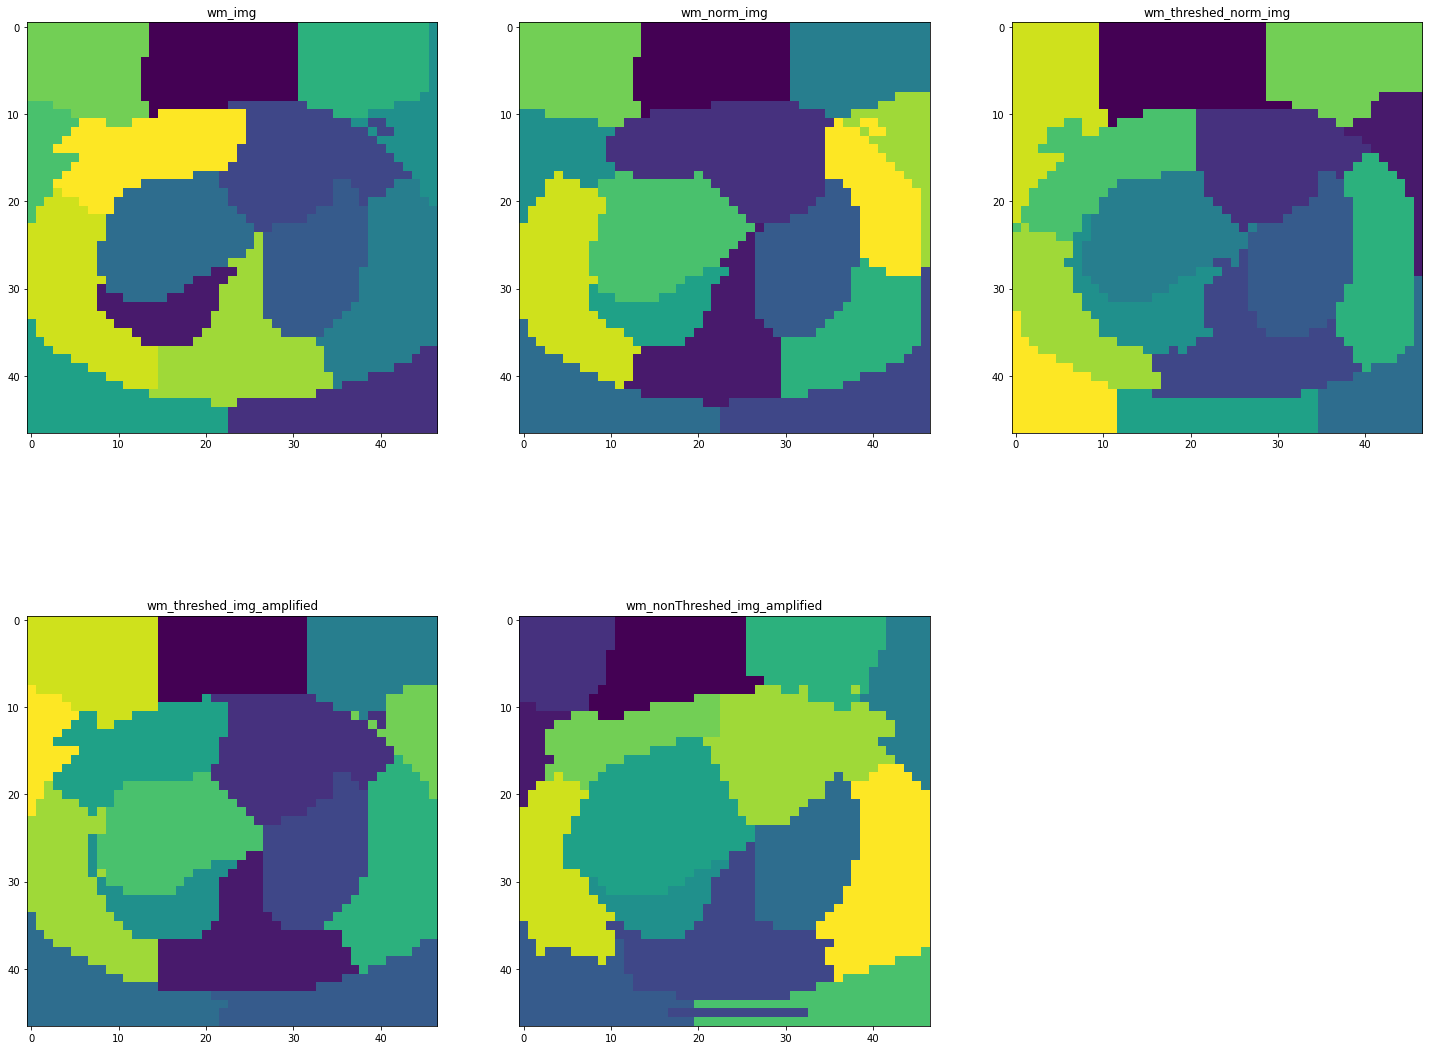

In [341]:
plt.figure(figsize=(25,20));
plt.subplot(231)
plt.imshow(labels_img) # wm_img
plt.title('wm_img')
plt.subplot(232)
plt.imshow(labels_norm_img) # wm_norm_img
plt.title('wm_norm_img')
plt.subplot(233)
plt.imshow(labels_threshed_norm_img) # wm_threshed_norm_img
plt.title('wm_threshed_norm_img')
plt.subplot(234)
plt.imshow(labels_threshed_img_amplified) # wm_threshed_img_amplified
plt.title('wm_threshed_img_amplified')
plt.subplot(235)
plt.imshow(labels_nonThreshed_img_amplified) # wm_nonThreshed_img_amplified
plt.title('wm_nonThreshed_img_amplified')
plt.show()

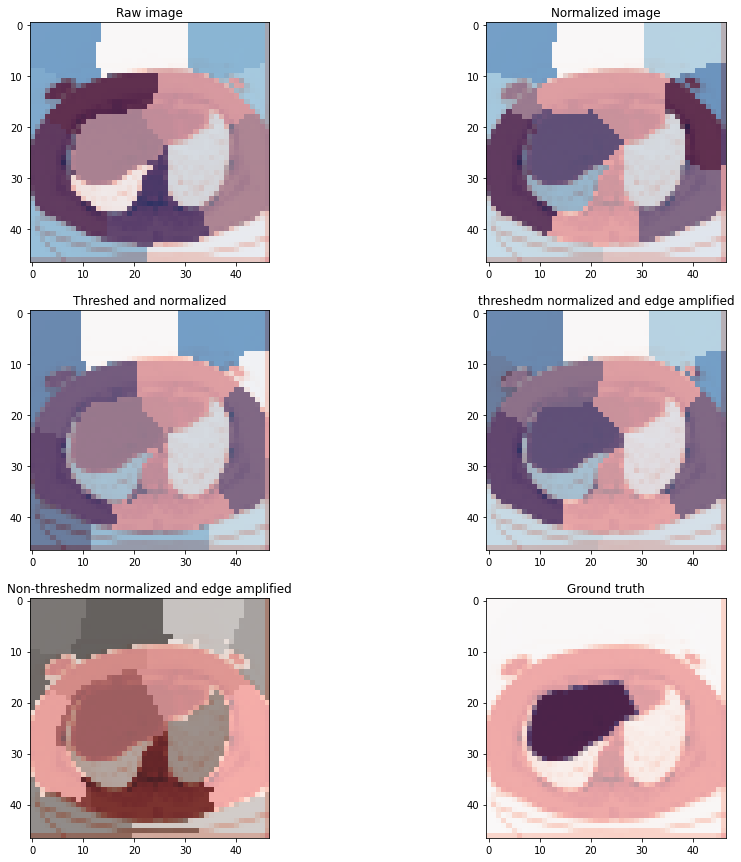

In [361]:
plt.figure(figsize=(15,15));
plt.subplot(321)
plt.imshow(_image, cmap='Reds')
plt.imshow(labels_img, cmap='Blues', alpha=0.6) #
plt.title('Raw image')
plt.subplot(322)
plt.imshow(_image, cmap='Reds')
plt.imshow(labels_norm_img, cmap='Blues', alpha=0.6)
plt.title('Normalized image')
plt.subplot(323)
plt.imshow(_image, cmap='Reds')
plt.imshow(labels_threshed_norm_img, cmap='Blues', alpha=0.6)
plt.title('Threshed and normalized')
plt.subplot(324)
plt.imshow(_image, cmap='Reds')
plt.imshow(labels_threshed_img_amplified, cmap='Blues', alpha=0.6)
plt.title('threshedm normalized and edge amplified')
plt.subplot(325)
plt.imshow(_image, cmap='Reds')
plt.imshow(labels_nonThreshed_img_amplified, cmap='Blues', alpha=0.6)
plt.title('Non-threshedm normalized and edge amplified')
plt.subplot(326)
plt.imshow(_image, cmap='Reds')
plt.imshow(_mask, cmap='Blues', alpha=0.6)
plt.title('Ground truth')
plt.show()

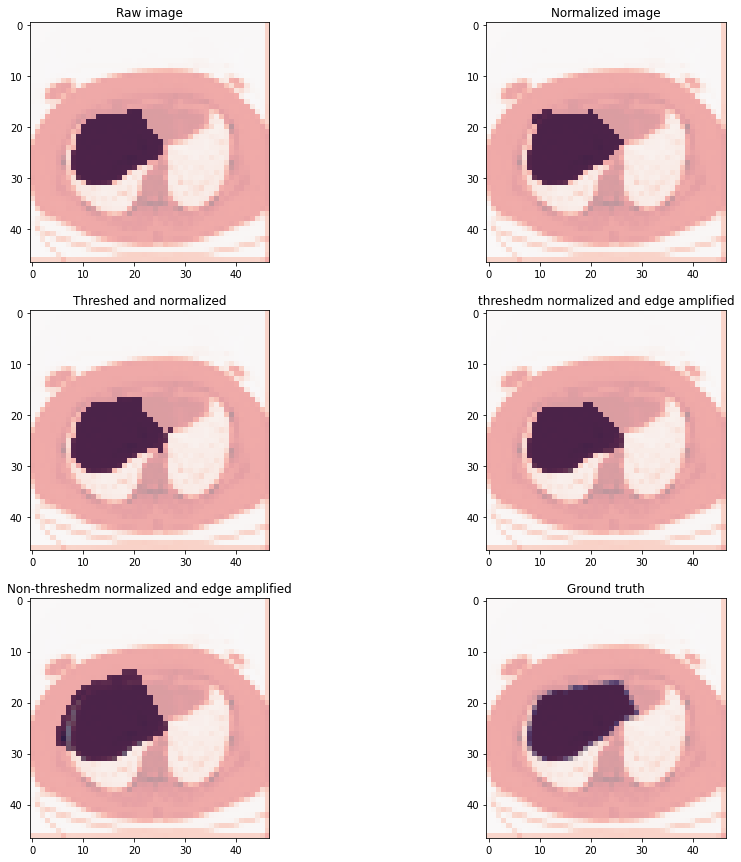

In [359]:
plt.figure(figsize=(15,15));
plt.subplot(321)
plt.imshow(_image, cmap='Reds')
plt.imshow(labels_img==5, cmap='Blues', alpha=0.6) #
plt.title('Raw image')
plt.subplot(322)
plt.imshow(_image, cmap='Reds')
plt.imshow(labels_norm_img==10, cmap='Blues', alpha=0.6)
plt.title('Normalized image')
plt.subplot(323)
plt.imshow(_image, cmap='Reds')
plt.imshow(labels_threshed_norm_img==6, cmap='Blues', alpha=0.6)
plt.title('Threshed and normalized')
plt.subplot(324)
plt.imshow(_image, cmap='Reds')
plt.imshow(labels_threshed_img_amplified==10, cmap='Blues', alpha=0.6)
plt.title('threshedm normalized and edge amplified')
plt.subplot(325)
plt.imshow(_image, cmap='Reds')
plt.imshow(labels_nonThreshed_img_amplified==8, cmap='Blues', alpha=0.6)
plt.title('Non-threshedm normalized and edge amplified')
plt.subplot(326)
plt.imshow(_image, cmap='Reds')
plt.imshow(_mask, cmap='Blues', alpha=0.6)
plt.title('Ground truth')
plt.show()
lbl_liver_list = [5, 10, 6, 10, 8] # when number of clusters is chosen to 15 and on discretize

In [318]:
# BDSCAN
# samples = 5
# eps = 0.5
# DBSCAN_img = DBSCAN(eps=eps, min_samples=samples).fit(wm_img)
# DBSCAN_norm_img = DBSCAN(eps=eps, min_samples=samples).fit(wm_norm_img)
# DBSCAN_threshed_norm_img =DBSCAN(eps=eps, min_samples=samples).fit(wm_threshed_norm_img)
# DBSCAN_threshed_img_amplified = DBSCAN(eps=eps, min_samples=samples).fit(wm_threshed_img_amplified)
# DBSCAN_nonThreshed_img_amplified = DBSCAN(eps=eps, min_samples=samples).fit(wm_nonThreshed_img_amplified)

# labels_DBSCAN_img = DBSCAN_img.labels_.reshape(_image.shape)
# labels_DBSCAN_norm_img = DBSCAN_norm_img.labels_.reshape(_image.shape)
# labels_DBSCAN_threshed_norm_img = DBSCAN_threshed_norm_img.labels_.reshape(_image.shape)
# labels_DBSCAN_threshed_img_amplified = DBSCAN_threshed_img_amplified.labels_.reshape(_image.shape)
# labels_DBSCAN_nonThreshed_img_amplified = DBSCAN_nonThreshed_img_amplified.labels_.reshape(_image.shape)

# plt.figure(figsize=(20,20));
# plt.subplot(231)
# plt.imshow(labels_DBSCAN_img)
# plt.subplot(232)
# plt.imshow(labels_DBSCAN_norm_img)
# plt.subplot(233)
# plt.imshow(labels_DBSCAN_threshed_norm_img)
# plt.subplot(234)
# plt.imshow(labels_DBSCAN_threshed_img_amplified)
# plt.subplot(235)
# plt.imshow(labels_DBSCAN_nonThreshed_img_amplified)
# plt.show()

DBSCAN_img.labels_ # noisy ssamples in weight matrix!! not dense so maybe this makes sense

array([-1, -1, -1, ..., -1, -1, -1], dtype=int64)

In [363]:
from matplotlib.cm import ScalarMappable
import networkx as nx

# Build graphs of the follwoing weight matrices
# wm_img # wm_norm_img # wm_threshed_norm_img # wm_threshed_img_amplified # wm_nonThreshed_img_amplified
gwm_img = nx.convert_matrix.from_numpy_matrix(wm_img)
gwm_norm_img = nx.convert_matrix.from_numpy_matrix(wm_norm_img)
gwm_threshed_norm_img = nx.convert_matrix.from_numpy_matrix(wm_threshed_norm_img)
gwm_threshed_img_amplified = nx.convert_matrix.from_numpy_matrix(wm_threshed_img_amplified)
gwm_nonThreshed_img_amplified = nx.convert_matrix.from_numpy_matrix(wm_nonThreshed_img_amplified)

graphs = [gwm_img, gwm_norm_img, gwm_threshed_norm_img, gwm_threshed_img_amplified, gwm_nonThreshed_img_amplified]

cc = []
for graph in graphs:
    cc.append(nx.average_clustering(graph))
cc # clustering koeff for the graphs

[0.6142208215593518,
 0.6142208215593518,
 0.6142208215593518,
 0.6142208215593518,
 0.6142208215593518]

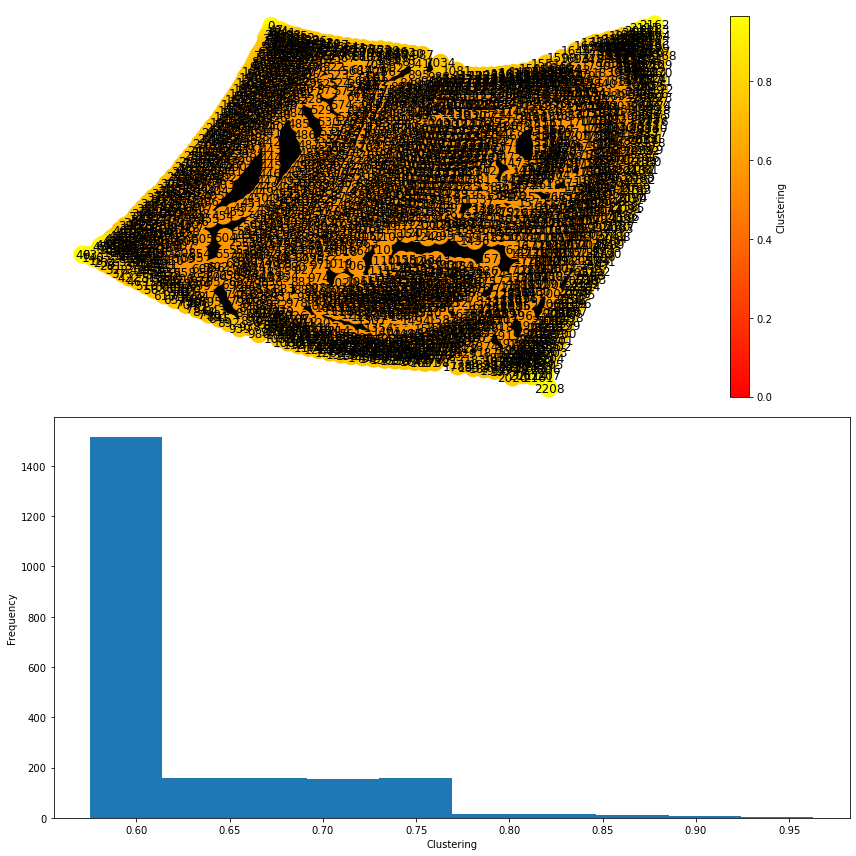

In [364]:
# plot the distribution of clustering koeff for all nodes in a graph
# https://stackoverflow.com/questions/64485434/how-to-plot-the-distribution-of-a-graphs-clustering-coefficient
gc = gwm_img.subgraph(max(nx.connected_components(gwm_img)))
lcc = nx.clustering(gc)

cmap = plt.get_cmap('autumn')
norm = plt.Normalize(0, max(lcc.values()))
node_colors = [cmap(norm(lcc[node])) for node in gc.nodes]
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 12))
nx.draw_spring(gc, node_color=node_colors, with_labels=True, ax=ax1)
fig.colorbar(ScalarMappable(cmap=cmap, norm=norm), label='Clustering', shrink=0.95, ax=ax1)


ax2.hist(lcc.values(), bins=10)
ax2.set_xlabel('Clustering')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [365]:
# normalized cut value
lbl = lbl_liver_list[0]
sub = gwm_img.subgraph(list((np.where(clustering_norm_img.labels_==lbl))[0])) # obtained from plot above
nc = nx.normalized_cut_size(gwm_img, sub)
print('normalized cut value for the label {} is: {}'.format(lbl, nc));

normalized cut value for the label 5 is: 0.2881582468956346


In [366]:
dens = nx.density(gwm_img)
inf = nx.info(gwm_img)
print(inf)
print('density of graph g: ',dens)

Name: 
Type: Graph
Number of nodes: 2209
Number of edges: 97847
Average degree:  88.5894
density of graph g:  0.040122014026938546


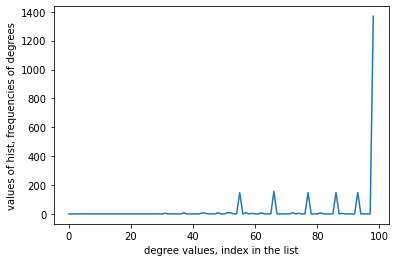

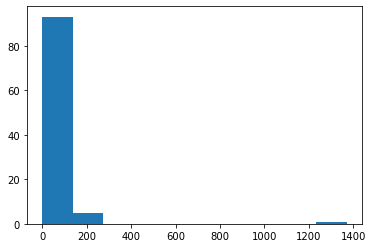

In [367]:
# https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.degree_histogram.html#networkx.classes.function.degree_histogram 
# hist, A list of frequencies of degrees. The degree values are the index in the list
hist = nx.degree_histogram(gwm_img)

plt.plot(range(0,len(hist),1), hist)
plt.xlabel('degree values, index in the list')
plt.ylabel('values of hist, frequencies of degrees')
plt.show()
plt.hist(hist)
plt.show()

In [382]:
eig_values = np.linalg.eig(wm_img);
# print(eig_values[1][:])

(array([0], dtype=int64),)


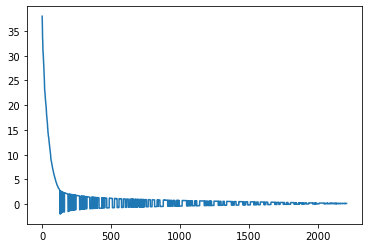

In [381]:
print(np.where(np.max(eig_values[0]))) # --> 37
plt.plot(eig_values[0]) 


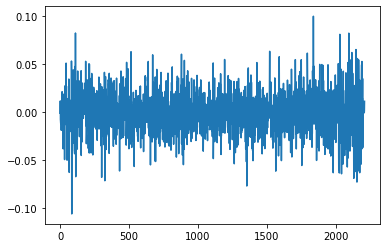

In [372]:
plt.plot(eig_values[1][0]); # plot first eigenVector

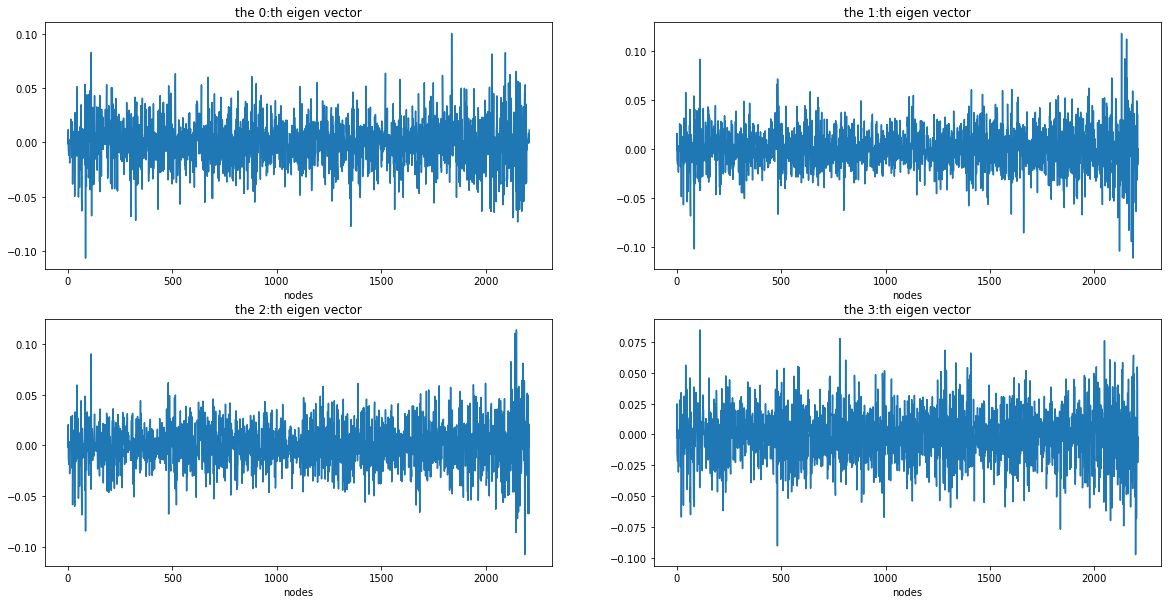

In [373]:
plt.figure(figsize=(20,10));
plt.subplot(2, 2, 1);
plt.plot(eig_values[1][0]);
plt.xlabel('nodes');
plt.title('the {}:th eigen vector'.format(0));
plt.subplot(2, 2, 2);
plt.plot(eig_values[1][1]);
plt.xlabel('nodes');
plt.title('the {}:th eigen vector'.format(1));
plt.subplot(2, 2, 3);
plt.plot(eig_values[1][2]);
plt.xlabel('nodes');
plt.title('the {}:th eigen vector'.format(2));
plt.subplot(2, 2, 4);
plt.plot(eig_values[1][3]);
plt.xlabel('nodes');
plt.title('the {}:th eigen vector'.format(3));
plt.show();

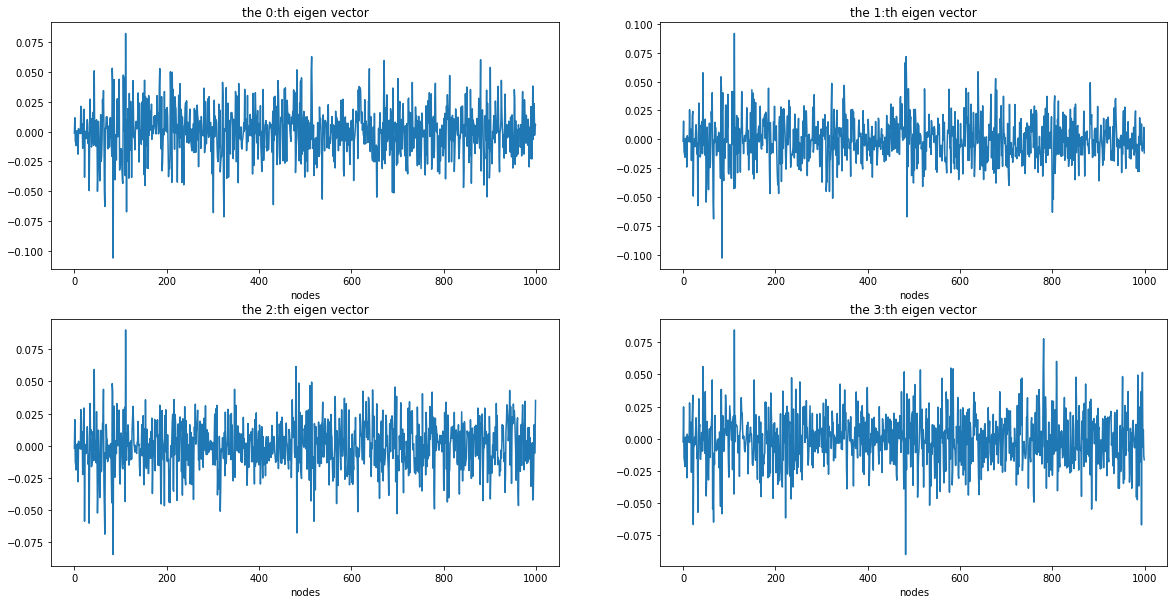

In [374]:
plt.figure(figsize=(20,10));
plt.subplot(2, 2, 1);
plt.plot(eig_values[1][0][0:1000]);
plt.xlabel('nodes');
plt.title('the {}:th eigen vector'.format(0));
plt.subplot(2, 2, 2);
plt.plot(eig_values[1][1][0:1000]);
plt.xlabel('nodes');
plt.title('the {}:th eigen vector'.format(1));
plt.subplot(2, 2, 3);
plt.plot(eig_values[1][2][0:1000]);
plt.xlabel('nodes');
plt.title('the {}:th eigen vector'.format(2));
plt.subplot(2, 2, 4);
plt.plot(eig_values[1][3][0:1000]);
plt.xlabel('nodes');
plt.title('the {}:th eigen vector'.format(3));
plt.show();

In [369]:
diagonal_vector = np.sum(wm_img, axis=1)
Diagonal_matrix = np.diag(diagonal_vector)
Laplasian_matrix = Diagonal_matrix - wm_img

# https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html


In [82]:
# np.savetxt("Ahmad_simi_matrix.csv", g, fmt='%1.4f', delimiter=",")
# imwrite(str("Ahmad_simi_matrix.png"), g)
# i = imread("Ahmad_simi_matrix.png");
# i = i/np.max(i)

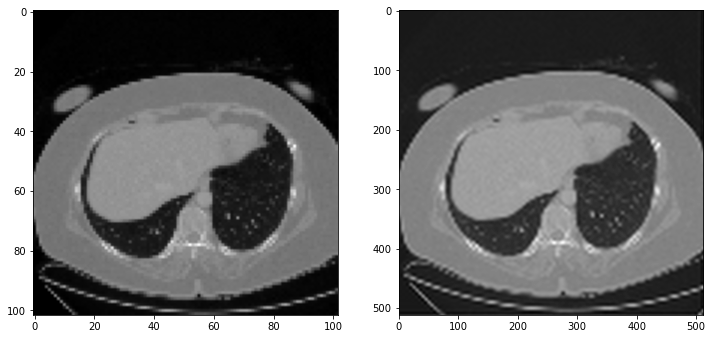

In [39]:
# test to go back to original size, loose resolution! maybe it's okey, we only need to obtain a segmentation mask to
# put on/merge with the original image!
# invers_scaling_factor = 1/scaling_factor;
# transf_matrix = give_transferMatrix([invers_scaling_factor , invers_scaling_factor]);

# # https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.ndimage.interpolation.affine_transform.html
# ssd_reg_img_test = ndi.interpolation.affine_transform(ssd_reg_img, transf_matrix, offset=(0, 0))

# plt.figure(figsize=(12,8))
# plt.subplot(1, 2, 1)
# plt.imshow(scaled_image, cmap='gray')
# plt.subplot(1, 2, 2)
# plt.imshow(ssd_reg_img_test, cmap='gray')
# plt.show()